In [54]:
from sklearn import ensemble, model_selection, tree, metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ejercicio 1

Pensamos en usar 20% de test para tener mas confianza en los resultados de nuestros modelos. 10% nos parecio muy bajo (50 datos).

Vamos a usar K-Fold para validar el modelo con el fine-tuning.

(?) usar stratified en test

In [55]:
datos = pd.read_csv("datos/data.csv")
datos = datos.sample(frac=1).reset_index(drop=True) # Permuto las filas al azar x si estaban ordenadas

y = datos['target']
X = datos.iloc[:, :-1]

In [56]:
def desarrollo_evaluacion(X, y, prop_train):
    return X[:int(len(X)*prop_train)], y[:int(len(X)*prop_train)], X[int(len(X)*prop_train):], y[int(len(X)*prop_train):]

In [57]:
X_train, y_train, X_test, y_test = desarrollo_evaluacion(X, y, 0.8)

# Ejercicio 2

In [58]:
arbol = tree.DecisionTreeClassifier(max_depth=3)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

(!) average_precision es ~AUPRC

In [59]:
metricas = ['accuracy', 'roc_auc', 'average_precision']
scores = model_selection.cross_validate(arbol, X_train, y_train, cv = 5, scoring = metricas, return_train_score=True, return_estimator=True, return_indices=True)

In [60]:
for metrica in list(scores.keys())[4:]:
    scores[metrica] = {'permutacion': scores[metrica], 'promedio': np.mean(scores[metrica])}

scores

{'fit_time': array([0.01771021, 0.01764989, 0.01752782, 0.0175786 , 0.01751804]),
 'score_time': array([0.0041573 , 0.00437069, 0.00409532, 0.00528407, 0.00424075]),
 'estimator': [DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3)],
 'indices': {'train': (array([ 69,  71,  73,  74,  82,  85,  86,  87,  88,  89,  90,  91,  92,
           93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
          106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
          119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
          132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
          145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
          158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
          171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     

(?) cross_val_predict

In [61]:
pred_folds = np.array([])
real_folds = np.array([])
for i in range(5):
    pred_folds = np.concatenate((pred_folds, scores['estimator'][i].predict(X_train.iloc[scores['indices']['test'][i]])))
    real_folds = np.concatenate((real_folds, y_train[scores['indices']['test'][i]]))

In [62]:
global_scores = {'accuracy': metrics.accuracy_score(real_folds, pred_folds),
                 'AUPRC': metrics.average_precision_score(real_folds, pred_folds),
                 'AUCROC': metrics.roc_auc_score(real_folds, pred_folds)}
global_scores

{'accuracy': 0.6875,
 'AUPRC': 0.39775629823794956,
 'AUCROC': 0.6197138222685667}

In [63]:
grilla = model_selection.ParameterGrid({'max_depth': [3, 5, None], 'criterion': ['gini', 'entropy']})
scores_grilla = []

for params in grilla:
    arbol = tree.DecisionTreeClassifier(**params)
    scores_grilla += [model_selection.cross_validate(arbol, X_train, y_train, cv=5, return_train_score=True)]
    scores_grilla[-1]['promedio_test'] = np.mean(scores_grilla[-1]['test_score'])
    scores_grilla[-1]['promedio_train'] = np.mean(scores_grilla[-1]['train_score'])

In [64]:
[param for param in grilla]

[{'criterion': 'gini', 'max_depth': 3},
 {'criterion': 'gini', 'max_depth': 5},
 {'criterion': 'gini', 'max_depth': None},
 {'criterion': 'entropy', 'max_depth': 3},
 {'criterion': 'entropy', 'max_depth': 5},
 {'criterion': 'entropy', 'max_depth': None}]

In [65]:
scores_grilla

[{'fit_time': array([0.0180645 , 0.01777649, 0.01788545, 0.01768446, 0.01742387]),
  'score_time': array([0.00140595, 0.00140476, 0.00185132, 0.00152421, 0.00139666]),
  'test_score': array([0.6875, 0.6625, 0.7375, 0.65  , 0.7   ]),
  'train_score': array([0.821875, 0.759375, 0.853125, 0.840625, 0.828125]),
  'promedio_test': 0.6875,
  'promedio_train': 0.820625},
 {'fit_time': array([0.02574921, 0.02635503, 0.02591705, 0.02598643, 0.02552295]),
  'score_time': array([0.0013864 , 0.00135493, 0.00139308, 0.00135469, 0.00134706]),
  'test_score': array([0.7125, 0.625 , 0.6625, 0.65  , 0.6375]),
  'train_score': array([0.94375 , 0.925   , 0.94375 , 0.909375, 0.971875]),
  'promedio_test': 0.6575,
  'promedio_train': 0.93875},
 {'fit_time': array([0.03218746, 0.03648806, 0.04958749, 0.04188609, 0.02882457]),
  'score_time': array([0.00135803, 0.0013454 , 0.0014174 , 0.00134611, 0.00134635]),
  'test_score': array([0.675 , 0.625 , 0.6375, 0.6375, 0.675 ]),
  'train_score': array([1., 1., 1.

(!) faltan conclusiones

- los ultimos dan 1 porque tienen altura maxima inf
- decir algo de entropy vs. gini

# Ejercicio 3

In [66]:
from sklearn import neighbors, svm, discriminant_analysis, naive_bayes

In [67]:
tree_params = {'max_depth': [i for i in range(1, 20)], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2']}
knn_params = {'n_neighbors': [i for i in range(1, 20)], 'metric': ['l1', 'l2', 'cosine']}
svm_params = {'C': np.linspace(1, 10, 20), 'tol': [10 ** -i for i in range(1, 6)], 'kernel': ['linear', 'rbf']}
lda_params = {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 1.0]}
naive_params = {'priors': [[i, 1-i] for i in np.linspace(0, 1, 100)]}

In [68]:
modelos = {
    tree.DecisionTreeClassifier: tree_params,
    neighbors.KNeighborsClassifier: knn_params,
    svm.SVC: svm_params,
    discriminant_analysis.LinearDiscriminantAnalysis: lda_params,
    naive_bayes.GaussianNB: naive_params
}

results = {}
mejores = []

for modelo, params in modelos.items():
    search = model_selection.RandomizedSearchCV(estimator=modelo(),
                                       param_distributions=params,
                                       scoring='roc_auc')
    search.fit(X_train, y_train)
    results[modelo] = search.cv_results_
    mejores.append(search.best_estimator_)

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py", line 637, in fit
    self._solve_eigen(
  File "/home/godo/.local/lib

In [69]:
excl = ['params', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score', 'rank_test_score']
for modelo in modelos:
    print(pd.DataFrame(results[modelo]).drop(excl, axis=1).sort_values('mean_test_score', ascending=False))
    print('\n\n')

  param_max_features param_max_depth param_criterion  mean_test_score
7               log2               1            gini         0.594043
2               log2              10        log_loss         0.579109
0               sqrt              13         entropy         0.572124
6               sqrt              18        log_loss         0.562485
9               sqrt               8            gini         0.558330
4               sqrt               9            gini         0.555711
1               log2              17        log_loss         0.543389
3               sqrt              10         entropy         0.529092
8               log2               8            gini         0.526691
5               log2               1        log_loss         0.505803



  param_n_neighbors param_metric  mean_test_score
3                14           l1         0.840409
8                17           l1         0.838770
6                19           l2         0.812425
1                11        

In [70]:
for modelo in results:
    print(modelo, max(results[modelo]['mean_test_score']))

<class 'sklearn.tree._classes.DecisionTreeClassifier'> 0.594042994042994
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 0.8404085988085989
<class 'sklearn.svm._classes.SVC'> 0.8738463610463609
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'> 0.8657897953897955
<class 'sklearn.naive_bayes.GaussianNB'> 0.7918483294483296


In [71]:
for modelo in mejores:
    print(modelo)

DecisionTreeClassifier(max_depth=1, max_features='log2')
KNeighborsClassifier(metric='l1', n_neighbors=14)
SVC(C=3.8421052631578947)
LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')
GaussianNB(priors=[0.797979797979798, 0.202020202020202])


# Ejercicio 4

Arbol de decision, LDA, SVM

Text(0.5, 1.0, 'Curva de aprendizaje para SVM')

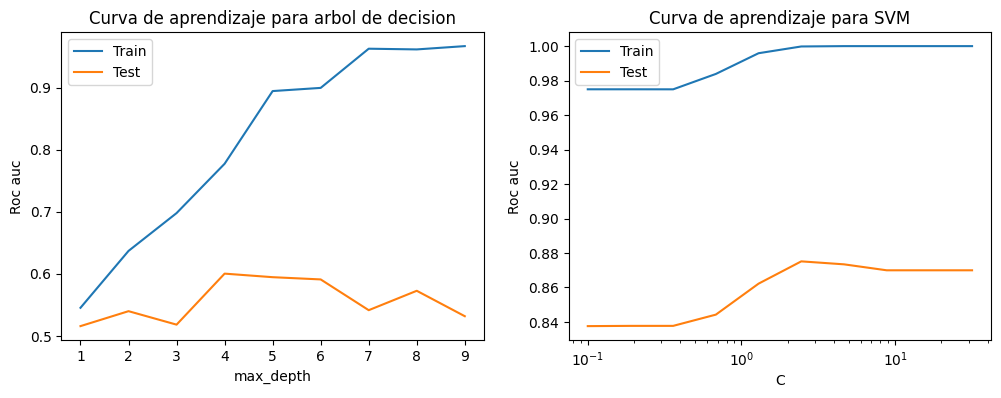

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

model_selection.ValidationCurveDisplay.from_estimator(
    mejores[0], X_train, y_train, param_name='max_depth', param_range=[i for i in range(10)], std_display_style=None, scoring='roc_auc', ax=ax[0]
)
ax[0].set_title(f"Curva de aprendizaje para arbol de decision")

model_selection.ValidationCurveDisplay.from_estimator(
    mejores[2], X_train, y_train, param_name='C', param_range=np.logspace(-1, 1.5, 10), std_display_style=None, scoring='roc_auc', ax=ax[1]
)
ax[1].set_title(f"Curva de aprendizaje para SVM")

(DecisionTree) aumentar max depth hace que el modelo overfittee. Sin embargo, en evaluacion la performance no mejora.

(SVM) A mayores valores de C el modelo es menos "regular". SVM se satura alrededor de C=5 y el score de test converge (ademas train llega al maximo, 1).

In [ ]:
# Usamos siempre el mismo conjunto de validacion (el ultimo 20%, porque permutamos los datos)
train_test_indices = [([i for i in range(320)], [i for i in range(320, 400)])]

In [86]:
[(i, modelo) for i, modelo in enumerate(mejores)]

[(0, DecisionTreeClassifier(max_depth=1, max_features='log2')),
 (1, KNeighborsClassifier(metric='l1', n_neighbors=14)),
 (2, SVC(C=3.8421052631578947)),
 (3, LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')),
 (4, GaussianNB(priors=[0.797979797979798, 0.202020202020202]))]

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_resp

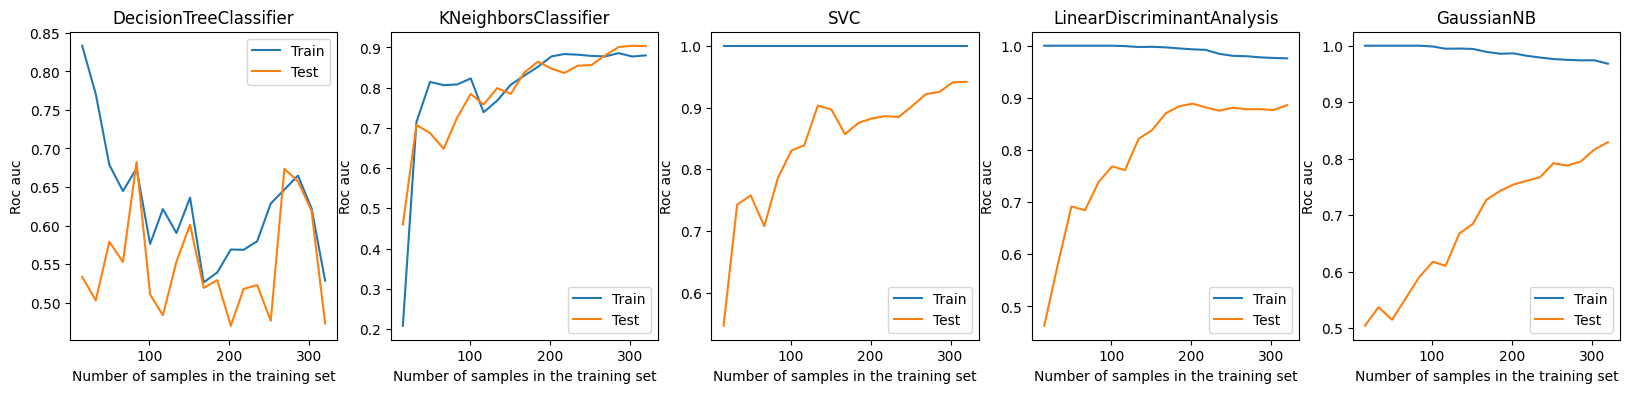

In [90]:
fig, ax = plt.subplots(1, len(mejores), figsize=(20,4))
for i, modelo in enumerate(mejores):
    model_selection.LearningCurveDisplay.from_estimator(
        modelo, X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), scoring='roc_auc', cv=train_test_indices, ax=ax[i]
    )
    ax[i].set_title(modelo.__class__.__name__)


Para el arbol de decision mas datos no mejora el rendimiento. El modelo ya separo el espacio lo mejor que pudo con los parametros dados.

El grafico parece haber convergido. Sin embargo, es creciente hasta el final asi que podria mejorar con mas datos de entrenamiento.

Para LDA la curva de aprendizaje tambien es creciente, asi que el modelo no llego a overfitear (baja varianza o sesgo alto). Con mas datos puede mejorar la performance.

## Random forest

In [ ]:
random_forest = ensemble.RandomForestClassifier(n_estimators=200)

(!) usar randomizedsearchcv para los otros parametros

In [ ]:
search = model_selection.RandomizedSearchCV(random_forest, param_distributions={'max_depth': [i for i in range(20)], 'criterion': ['gini', 'entropy', 'log_loss']})
search.fit(X_train, y_train)
pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.460930,0.003269,0.006927,0.000178,10,gini,"{'max_depth': 10, 'criterion': 'gini'}",0.7000,0.7125,0.7000,0.7000,0.7000,0.7025,0.005000,1
5,0.534663,0.009840,0.008067,0.001240,9,log_loss,"{'max_depth': 9, 'criterion': 'log_loss'}",0.6875,0.7125,0.7125,0.6875,0.7000,0.7000,0.011180,2
0,0.553041,0.014599,0.007929,0.001239,19,log_loss,"{'max_depth': 19, 'criterion': 'log_loss'}",0.7000,0.7125,0.7000,0.6750,0.6875,0.6950,0.012748,3
8,0.527287,0.003947,0.006853,0.000040,16,log_loss,"{'max_depth': 16, 'criterion': 'log_loss'}",0.7000,0.7000,0.6875,0.6750,0.7000,0.6925,0.010000,4
3,0.528822,0.002936,0.007150,0.000371,14,entropy,"{'max_depth': 14, 'criterion': 'entropy'}",0.7000,0.7250,0.7000,0.6500,0.6875,0.6925,0.024495,5
1,0.492590,0.009141,0.006954,0.000063,19,gini,"{'max_depth': 19, 'criterion': 'gini'}",0.7000,0.7000,0.7000,0.6750,0.6875,0.6925,0.010000,6
6,0.532374,0.004082,0.007115,0.000173,18,log_loss,"{'max_depth': 18, 'criterion': 'log_loss'}",0.6875,0.7000,0.7000,0.6875,0.6750,0.6900,0.009354,7
9,0.365205,0.001149,0.006605,0.000139,5,gini,"{'max_depth': 5, 'criterion': 'gini'}",0.7000,0.6875,0.6750,0.6625,0.6875,0.6825,0.012748,8
2,0.400572,0.002905,0.006707,0.000184,4,log_loss,"{'max_depth': 4, 'criterion': 'log_loss'}",0.6875,0.6875,0.6875,0.6750,0.6750,0.6825,0.006124,9
4,0.277934,0.000341,0.006373,0.000129,2,log_loss,"{'max_depth': 2, 'criterion': 'log_loss'}",0.6875,0.6875,0.6750,0.6750,0.6750,0.6800,0.006124,10


Text(0.5, 1.0, 'Random forest')

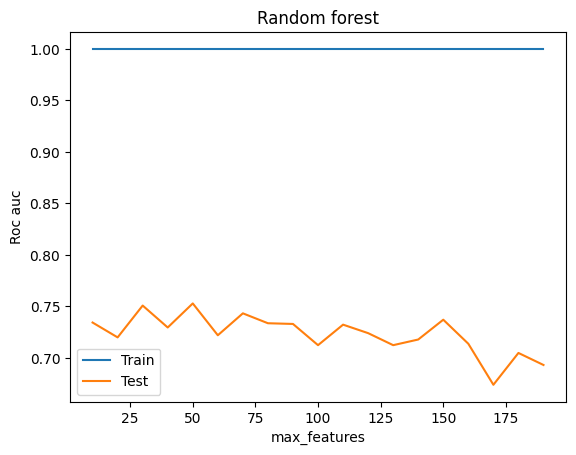

In [ ]:
np.random.seed(123)
random_forest = search.best_estimator_
ValidationCurveDisplay.from_estimator(random_forest, X_train, y_train, param_name='max_features', param_range=[i for i in range(0, 200, 10)], std_display_style=None, cv=train_test_indices, scoring='roc_auc')
plt.title('Random forest')

Para los datos, max_features no mejora el rendimiento del random forest.

/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
  File "/home/godo/.local/lib/python3.10/site-packages/sklearn/utils/_response.py", line 213, in _get_resp

Text(0.5, 1.0, 'Random forest')

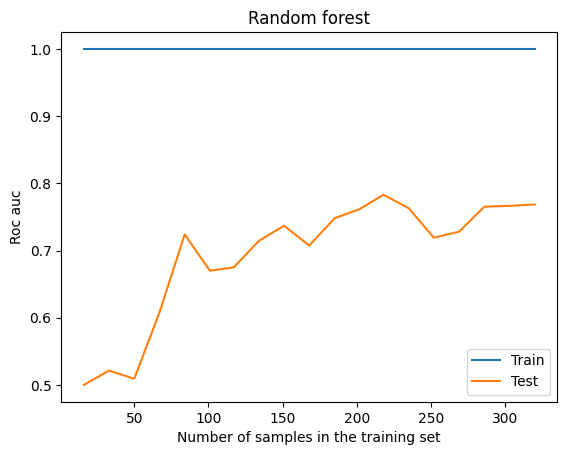

In [ ]:
np.random.seed(123)
LearningCurveDisplay.from_estimator(random_forest, X_train, y_train, std_display_style=None, train_sizes = np.linspace(0.00001, 1, 20), cv=train_test_indices, scoring='roc_auc')
plt.title('Random forest')

El rendimiento en evaluacion mejora con mas instancias.

## Ejercicio 5

In [ ]:
X_held_out = pd.read_csv('datos/X_held_out.csv')
X_held_out

,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,...,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199
0,-1.106151,-5.611131,2.712683,-0.529517,-3.831639,0.672653,5.333427,0.108881,0.069763,0.609721,...,-2.388832,-3.575021,-0.195262,-1.329819,-0.615811,-0.149399,0.976335,0.245581,-1.301849,0.729059
1,-0.266336,-2.918979,-1.006739,-0.096504,-3.009074,0.297644,-16.247286,0.011176,1.517002,-0.145927,...,-0.289372,-6.945991,1.973832,1.709684,-0.637233,-1.125183,-0.388908,0.645088,0.258491,1.538284
2,-0.139785,-5.756247,3.459090,3.011876,0.487198,0.533537,-33.141916,0.520467,-1.259532,1.434195,...,0.452060,-1.663599,0.163550,-0.889856,-1.884028,-0.780582,-2.693877,0.507226,0.862945,-0.655356
3,-0.185081,0.841544,9.382768,6.086935,2.288472,-2.844599,41.278200,-0.247986,0.537805,-0.519840,...,-1.990920,7.234289,-0.541081,-0.974709,-0.196730,-0.831564,-0.664984,-0.249332,-0.477191,-1.193948
4,0.971970,-2.962117,4.602942,1.043721,-0.016791,-0.772379,1.816865,-0.980162,-0.114072,-0.864194,...,1.525412,23.118892,-0.503892,0.172780,-0.798356,-0.368429,0.277803,-0.428431,1.802202,0.426170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.566337,0.512514,4.594405,-2.705414,1.890147,0.742073,-18.456021,1.102414,0.891122,0.311605,...,5.517851,11.471693,0.093960,-0.232578,-0.309831,-0.028813,-0.938506,0.155053,0.123868,-1.328063
496,0.700373,-6.066661,-6.075214,-1.155673,-0.657031,0.186253,-4.231492,-0.619254,-0.791117,0.798235,...,-4.989733,-10.175124,-1.455930,1.057059,-1.123295,-0.924695,-0.724669,-0.795370,-0.270905,1.506184
497,0.777344,-7.176908,3.354252,3.942897,-1.569569,1.604099,6.729852,0.741177,0.995905,1.283633,...,1.544407,18.577471,-0.027807,0.694708,-0.273394,0.481717,0.916152,-0.592327,-0.988314,1.642040
498,0.052583,-2.996524,-5.692944,1.778892,-3.468169,-0.881855,-23.259602,0.980070,-2.928452,-0.384283,...,2.657637,-4.861505,0.976821,0.030431,-1.901067,1.638674,1.400128,-0.306662,0.500872,-0.769428


In [ ]:
params_svm = mejores[2].get_params()
params_svm['probability'] = True

In [ ]:
svm_proba = svm.SVC(**params_svm)
svm_proba.fit(X_train, y_train)

SVC(C=10.0, probability=True, tol=0.01)

# Tuning: SVM pistero

In [ ]:
svm_eval = np.round(svm_proba.predict_proba(X_held_out)[:, 0], 4)

In [ ]:
lda_eval = np.round(mejores[3].predict_proba(X_held_out)[:, 0], 4)

In [ ]:
svm_params = {'C': np.linspace(0, 100, 50), 'tol': np.logspace(-20, 2, 50), 'kernel': ['linear', 'rbf']}

In [ ]:
search_svm = model_selection.RandomizedSearchCV(svm.SVC(), param_distributions=svm_params, scoring='roc_auc', n_iter=2, n_jobs=-1)
search_svm.fit(X_train, y_train)

KeyboardInterrupt: 

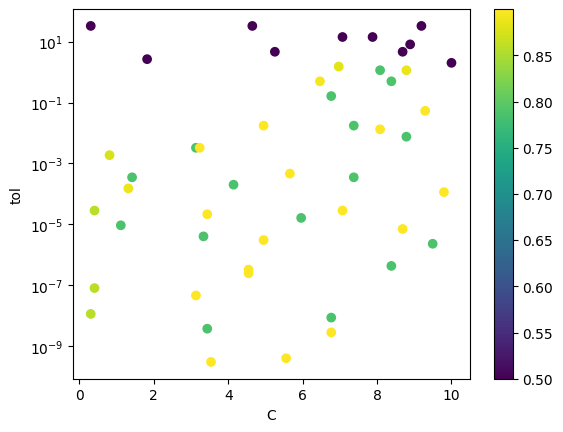

In [ ]:
plt.scatter(search_svm.cv_results_['param_C'], search_svm.cv_results_['param_tol'], c=search_svm.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('tol')
plt.yscale('log')
plt.colorbar()